<a href="https://colab.research.google.com/github/raquel1313/EvaluacionFML/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bosque aleatorio
Objetivo:

Predecir cuántos headshots por ronda (RoundHeadShots) realizará un jugador en Counter-Strike, utilizando un modelo de regresión random forest.


##Preparación de los datos
Carga de librerías y datos

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import files
import pandas as pd # Importing the pandas library

uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
df = pd.read_csv(name, sep=";") # Now pd is defined and can be used

Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022.csv


<ipython-input-2-fcaa96ee5f9c>:7: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, sep=";") # Now pd is defined and can be used


In [ ]:
df.head()

,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,600,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,750,4400,0,0,0,0
1,601,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,800,4400,0,0,0,0
2,602,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,1000,4400,0,0,0,0
3,603,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,850,4400,0,0,0,0
4,604,de_inferno,Terrorist,1,4,1,False,True,True,False,...,0,0,0,0,1000,4400,0,0,0,0


##Limpieza de datos

Selección de variables


##Seleccion de variables
Seleccionamos estas variables ya que en el primer informe vimos que son las que tienen una correlacion mas fuerte con nuestra variable objetivo\
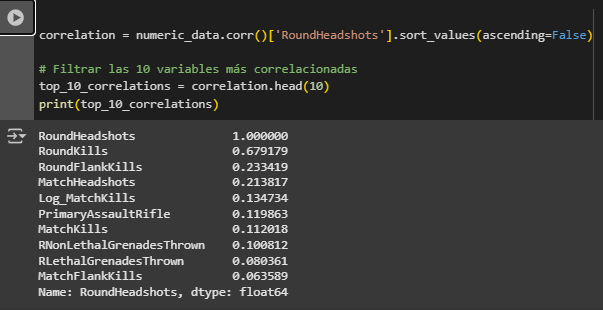

In [ ]:
# Lista de columnas a conservar (features + target)
columnas = [
    'MatchKills',
    'RoundKills',
    'RoundAssists',
    'RoundFlankKills',
    'RoundStartingEquipmentValue',
    'PrimaryAssaultRifle',
    'PrimarySniperRifle',
    'RoundHeadshots'  # target
]

# Crear nuevo DataFrame
df2 = df[columnas].copy()

# Mostrar primeras filas para confirmar
df2.head()

,MatchKills,RoundKills,RoundAssists,RoundFlankKills,RoundStartingEquipmentValue,PrimaryAssaultRifle,PrimarySniperRifle,RoundHeadshots
0,0,0,0,0,750,0.0,0.0,0
1,0,0,0,0,800,0.0,0.0,0
2,0,0,0,0,1000,0.0,0.0,0
3,0,0,0,0,850,0.0,0.0,0
4,0,0,0,0,1000,0.0,0.0,0


In [ ]:
# Ver cantidad de valores nulos por columna
print(df2.isnull().sum())

MatchKills                     0
RoundKills                     0
RoundAssists                   0
RoundFlankKills                0
RoundStartingEquipmentValue    0
PrimaryAssaultRifle            0
PrimarySniperRifle             0
RoundHeadshots                 0
dtype: int64


In [ ]:
# Verificar tipos
print(df2.dtypes)

MatchKills                       int64
RoundKills                       int64
RoundAssists                     int64
RoundFlankKills                  int64
RoundStartingEquipmentValue      int64
PrimaryAssaultRifle            float64
PrimarySniperRifle             float64
RoundHeadshots                   int64
dtype: object


In [ ]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
MatchKills,79157.0,8.511578,6.195079,0.0,3.0,8.0,13.0,41.0
RoundKills,79157.0,0.671349,0.881798,0.0,0.0,0.0,1.0,5.0
RoundAssists,79157.0,0.146178,0.385601,0.0,0.0,0.0,0.0,4.0
RoundFlankKills,79157.0,0.095633,0.320641,0.0,0.0,0.0,0.0,5.0
RoundStartingEquipmentValue,79157.0,3778.108695,2111.285406,0.0,1600.0,4700.0,5200.0,8850.0
PrimaryAssaultRifle,79157.0,0.675363,0.464125,0.0,0.0,1.0,1.0,1.0
PrimarySniperRifle,79157.0,0.089840,0.279797,0.0,0.0,0.0,0.0,1.0
RoundHeadshots,79157.0,0.301553,0.578843,0.0,0.0,0.0,0.0,5.0


In [ ]:
# Separar features y target
X = df2.drop('RoundHeadshots', axis=1)
y = df2['RoundHeadshots']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Entrenar modelo

In [ ]:
# Crear el modelo
rf_model = RandomForestRegressor(random_state=42)

# Entrenar
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

##Predecimos y evaluamos

In [ ]:
# Predecir
y_pred = rf_model.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


MAE: 0.2471
MSE: 0.1945
RMSE: 0.4410
R²: 0.4250


In [ ]:
# 1. Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# 2. Definir grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 3. Configurar el GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # validación cruzada con 3 particiones
    scoring='neg_mean_squared_error',  # puedes cambiar a 'r2' o 'neg_mean_absolute_error'
    n_jobs=-1,  # usar todos los núcleos disponibles
    verbose=2
)

# 4. Ejecutar la búsqueda
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# Mostrar mejores hiperparámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Mejor modelo
best_rf = grid_search.best_estimator_

# Predicción y evaluación
y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nEvaluación del mejor modelo:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Mejores parámetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}

Evaluación del mejor modelo:
MAE: 0.2389
MSE: 0.1679
RMSE: 0.4097
R²: 0.5037


Al limitar la profundidad a 10 y ajustar los nodos mínimos por división/hoja, el modelo generaliza mejor y reduce el sobreajuste.

El nuevo modelo explica el 50% de la variabilidad de los headshots (R² = 0.5037), frente al 42% del modelo base.

Todos los errores (MAE, MSE, RMSE) disminuyeron.